<a id='sec0'></a>
# PCAs
- Importing Data
- <a href='#sec1'>PCA with text-extracted features</a>
- <a href='#sec2'>PCA with features annotated in the variants file</a>
- <a href='#sec3'>PCA with both types of features</a>
- <a href='#sec4'>3D PCA and 3D-plots</a>
- <a href='#sec5'></a>
- <a href='#sec6'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import cm
import seaborn as sns
import re
import mskcc_functions as ski

from collections import Counter

from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

sns.set_context("paper")
%matplotlib inline

In [2]:
class_train = pd.read_csv('train_variants')
text_train = pd.read_csv('train_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

<a id='sec1'></a>
# PCA with text-extracted features (<a href='#sec0'>Back To Top</a>)

<b>Create a full mutation_type table, this time normalied to the total text size</b>

In [3]:
%%time
mut_words_list = []
for i in range(len(text_train)):
    text = text_train.loc[i, 'Text']
    tokens = ski.process_text1(text)
    mut_words = ski.create_mutation_words_table(tokens, normed='total_text')
    mut_words_list.append(mut_words)
    
full_mutation_table = pd.DataFrame(mut_words_list)

CPU times: user 3min 39s, sys: 43.9 ms, total: 3min 39s
Wall time: 3min 39s


In [4]:
full_mutation_table.head(10)

,amplification,deletion,duplication,epigenetic,frame,fusion,insertion,overexpression,promoter,splice,subtype,truncation,wildtype
0,0.000000,0.004632,0.000244,0.0,0.000244,0.001463,0.000244,0.000488,0.0,0.001219,0.000000,0.000244,0.0
1,0.000000,0.001101,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000275,0.000275,0.000000,0.0
2,0.000000,0.001101,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000275,0.000275,0.000000,0.0
3,0.000846,0.001693,0.000282,0.0,0.000000,0.000846,0.000000,0.001128,0.0,0.000000,0.000282,0.000000,0.0
4,0.000000,0.000000,0.000000,0.0,0.000249,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
5,0.000000,0.000000,0.000000,0.0,0.000249,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
6,0.000000,0.000000,0.000000,0.0,0.000249,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
7,0.000206,0.004523,0.000103,0.0,0.001028,0.000617,0.000206,0.000411,0.0,0.001336,0.001439,0.000000,0.0
8,0.000000,0.000000,0.000000,0.0,0.000128,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
9,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


<b>Create a full gene_like_words table</b>

In [5]:
%%time
genes = list(class_train['Gene'].unique())

glike_words_list = []
for i in range(len(text_train)):
    text = text_train.loc[i, 'Text']
    tokens = ski.process_text1(text)
    glike_words = ski.get_gene_like_words(tokens, gene_list=genes)
    c = dict(Counter(glike_words))
    glike_words_list.append(c)

full_glike_words_table = pd.DataFrame(glike_words_list)

CPU times: user 4min 3s, sys: 685 ms, total: 4min 4s
Wall time: 4min 4s


<b>2D-PCA on text-extracted features</b>

In [6]:
full_mutation_table = full_mutation_table.fillna(value=0)
full_glike_words_table = full_glike_words_table.fillna(value=0)
features1 = pd.concat([full_mutation_table, full_glike_words_table], axis=1)

In [7]:
X1 = np.array(features1).astype(float)
X1 = scale(X1)

In [8]:
# Create a new table with ID as index
pca_table1 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=2)
pca.fit(X1)
pca_table1['x'] = pca.fit_transform(X1).T[0]
pca_table1['y'] = pca.fit_transform(X1).T[1]

(-2.5, 10)

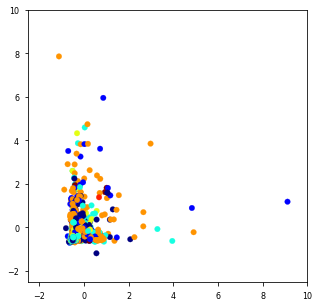

In [9]:
# Scatter x and y with color coding with cluster_id
plt.figure(figsize=(5, 5))
plt.scatter(pca_table1.x, pca_table1.y, c=class_train['Class'], marker = 'o', cmap = cm.jet)
plt.xlim([-2.5, 10])
plt.ylim([-2.5, 10])

<a id='sec2'></a>
# PCA with features annotated in the variants file (<a href='#sec0'>Back To Top</a>)

In [10]:
X_gene = np.array(class_train.Gene)
X_gene_int = LabelEncoder().fit_transform(X_gene.ravel()).reshape(-1, 1)
X_gene_bin = OneHotEncoder().fit_transform(X_gene_int).toarray()
full_gene_table = pd.DataFrame(X_gene_bin)

In [11]:
new_table = ski.convert_mutation_type(class_train)
X_mtype = np.array(new_table['mutation_type'])
X_mtype_int = LabelEncoder().fit_transform(X_mtype.ravel()).reshape(-1, 1)
X_mtype_bin = OneHotEncoder().fit_transform(X_mtype_int).toarray()
full_mtype_table = pd.DataFrame(X_mtype_bin)

In [12]:
full_gene_table = full_gene_table.fillna(value=0)
full_mtype_table = full_mtype_table.fillna(value=0)
features2 = pd.concat([full_gene_table, full_mtype_table], axis=1)

In [13]:
X2 = np.array(features2).astype(float)
X2 = scale(X2)

In [14]:
# Create a new table with ID as index
pca_table2 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=2)
pca.fit(X2)
pca_table2['x'] = pca.fit_transform(X2).T[0]
pca_table2['y'] = pca.fit_transform(X2).T[1]

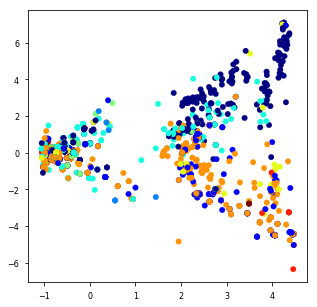

In [15]:
# Scatter x and y with color coding with cluster_id
plt.figure(figsize=(5, 5))
plt.scatter(pca_table2.x, pca_table2.y, c=class_train['Class'], marker = 'o', cmap = cm.jet)

<a id='sec3'></a>
# PCA with both types of features (<a href='#sec0'>Back To Top</a>)

In [81]:
features3 = pd.concat([full_mutation_table, full_glike_words_table, 
                       full_gene_table, full_mtype_table], axis=1)

In [82]:
X3 = np.array(features3).astype(float)
X3 = scale(X3)

In [83]:
# Create a new table with ID as index
pca_table3 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=2)
pca.fit(X3)
pca_table3['x'] = pca.fit_transform(X3).T[0]
pca_table3['y'] = pca.fit_transform(X3).T[1]

(-2.5, 10)

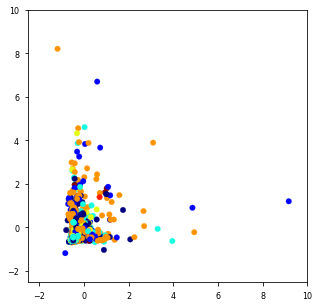

In [84]:
# Scatter x and y with color coding with cluster_id
plt.figure(figsize=(5, 5))
plt.scatter(pca_table3.x, pca_table3.y, c=class_train['Class'], marker = 'o', cmap = cm.jet)
plt.xlim([-2.5, 10])
plt.ylim([-2.5, 10])

<a id='sec4'></a>
# 3D PCA and 3D-plots (<a href='#sec0'>Back To Top</b>)

<b>PCA the variant-annotated features in 3D</b>

In [20]:
# Create a new table with ID as index
pca_table4 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X2)
pca_table4['x'] = pca.fit_transform(X2).T[0]
pca_table4['y'] = pca.fit_transform(X2).T[1]
pca_table4['z'] = pca.fit_transform(X2).T[2]

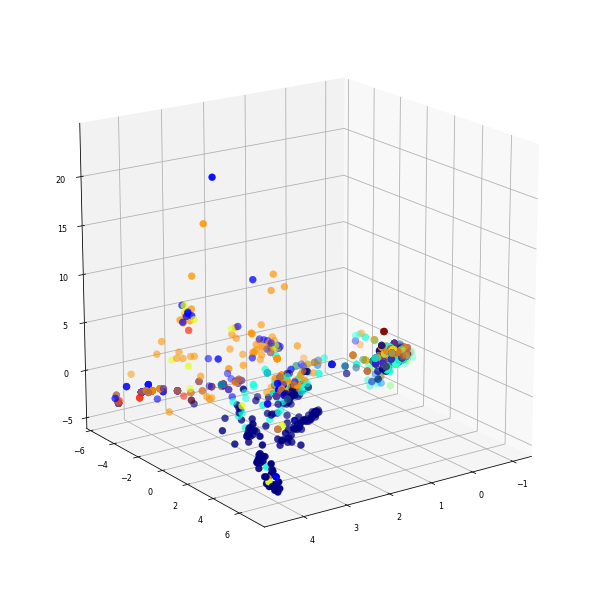

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])

ax.scatter(pca_table4.x, pca_table4.y, pca_table4.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

<b>PCA the variant-annotated gene feature alone in 3D</b>

In [22]:
X4 = np.array(full_gene_table).astype(float)
X4 = scale(X4)

In [49]:
# Create a new table with ID as index
pca_table5 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X4)
pca_table5['x'] = pca.fit_transform(X4).T[0]
pca_table5['y'] = pca.fit_transform(X4).T[1]
pca_table5['z'] = pca.fit_transform(X4).T[2]

In [50]:
pca.explained_variance_ratio_

array([ 0.00384859,  0.00382484,  0.00381634])

In [51]:
pca.n_components_

3

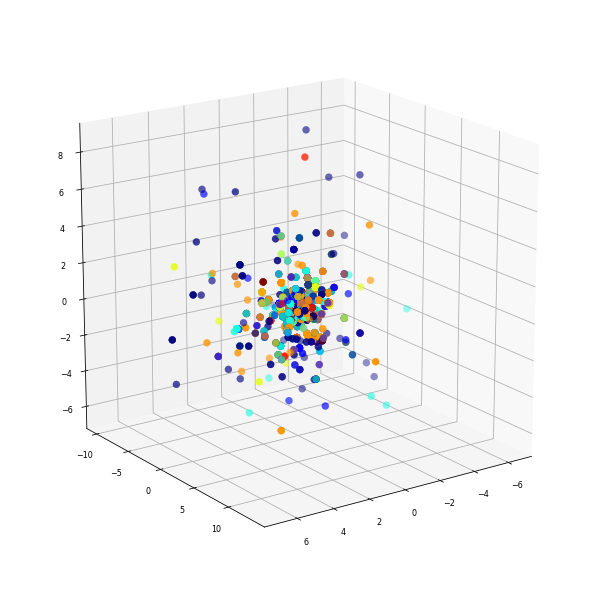

In [46]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])

ax.scatter(pca_table5.x, pca_table5.y, pca_table5.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

Mutation Type annotation seems to separate classes to an extent, especially the darker class one.

<b>PCA the variant-annotated features after removing "Point Mutation" type in 3D</b>

In [33]:
without_pmutation = new_table[new_table.mutation_type != 'Point Mutation']

In [35]:
without_pmutation.head(5)

,ID,Gene,Variation,mutation_type,Class
0,0,FAM58A,Truncating Mutations,Truncation,1
7,7,CBL,Deletion,Deletion,1
16,16,CBL,Truncating Mutations,Truncation,1
31,31,TERT,Promoter Mutations,Promoter Mutations,7
33,33,TERT,Amplification,Amplification,2


In [36]:
X_gene2 = np.array(without_pmutation.Gene)
X_gene_int2 = LabelEncoder().fit_transform(X_gene2.ravel()).reshape(-1, 1)
X_gene_bin2 = OneHotEncoder().fit_transform(X_gene_int2).toarray()
full_gene_table2 = pd.DataFrame(X_gene_bin2)

In [37]:
X_mtype2 = np.array(without_pmutation['mutation_type'])
X_mtype_int2 = LabelEncoder().fit_transform(X_mtype2.ravel()).reshape(-1, 1)
X_mtype_bin2 = OneHotEncoder().fit_transform(X_mtype_int2).toarray()
full_mtype_table2 = pd.DataFrame(X_mtype_bin2)

In [38]:
full_gene_table2 = full_gene_table2.fillna(value=0)
full_mtype_table2 = full_mtype_table2.fillna(value=0)
features4 = pd.concat([full_gene_table2, full_mtype_table2], axis=1)

In [39]:
X5 = np.array(features4).astype(float)
X5 = scale(X5)

In [41]:
# Create a new table with ID as index
pca_table6 = pd.DataFrame(index=without_pmutation.ID)
pca = PCA(n_components=3)
pca.fit(X5)
pca_table6['x'] = pca.fit_transform(X5).T[0]
pca_table6['y'] = pca.fit_transform(X5).T[1]
pca_table6['z'] = pca.fit_transform(X5).T[2]

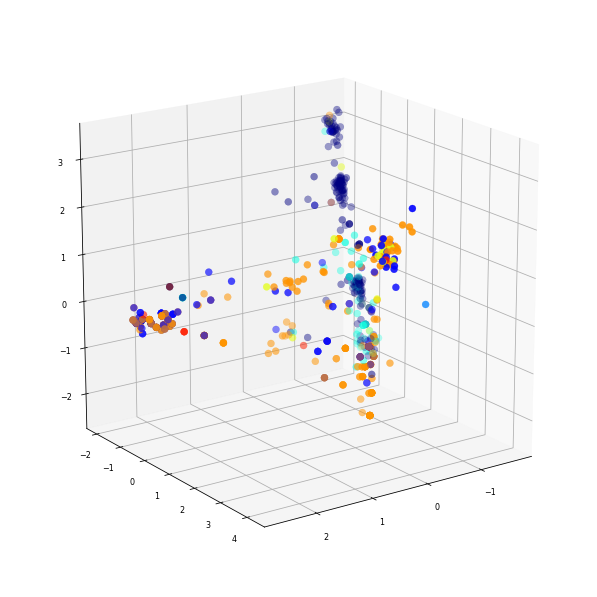

In [43]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])

ax.scatter(pca_table6.x, pca_table6.y, pca_table6.z, c=without_pmutation['Class'], marker = 'o', s=50, cmap = cm.jet)

<b>PCA all my features above in 3D</b>

In [85]:
# Create a new table with ID as index
pca_table7 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X3)
pca_table7['x'] = pca.fit_transform(X3).T[0]
pca_table7['y'] = pca.fit_transform(X3).T[1]
pca_table7['z'] = pca.fit_transform(X3).T[2]

(-2.5, 5)

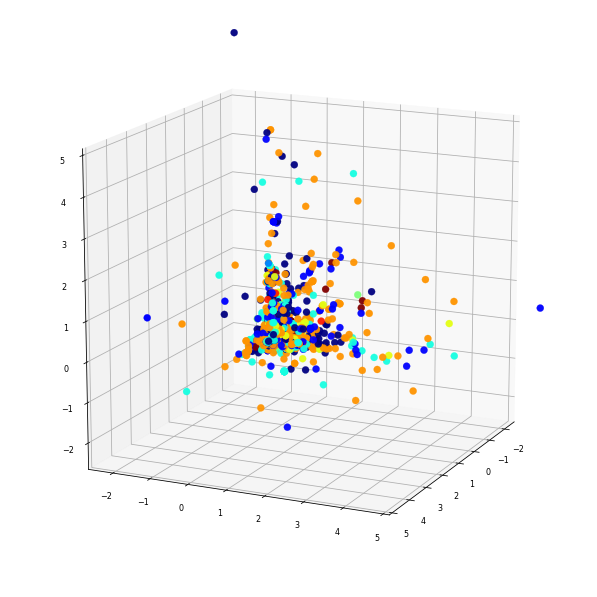

In [90]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=15, azim=25)#, rect=[0, 0, .95, 1])

ax.scatter(pca_table7.x, pca_table7.y, pca_table7.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)
ax.set_xlim3d([-2.5, 5])
ax.set_ylim3d([-2.5, 5])
ax.set_zlim3d([-2.5, 5])

This is not really useful as of now


# Classification by Random Forest in PCA space (<a href='#sec0'>Back To Top</b>)

<b>With Variant-File annotated features only</b>

In [61]:
# Create a new table with ID as index
pca = PCA()
X_pca = pca.fit_transform(X2)

In [62]:
X_pca.shape

(3321, 281)

In [63]:
X = X_pca.astype(float)
y = np.array(class_train.Class).astype(int).ravel()

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

In [65]:
%%time
rfc = RandomForestClassifier(n_estimators=50, max_depth=30)
rfc.fit(X_train, y_train)

CPU times: user 400 ms, sys: 1 ms, total: 401 ms
Wall time: 401 ms


In [66]:
y_pred = rfc.predict(X_test)

In [67]:
print(accuracy_score(y_test, y_pred))

0.598496240602


<b>With all features</b>

In [91]:
# Create a new table with ID as index
pca = PCA()
X_pca2 = pca.fit_transform(X3)

In [92]:
X_pca2.shape

(3321, 3321)

In [93]:
X2 = X_pca2.astype(float)
y = np.array(class_train.Class).astype(int).ravel()

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2)

In [95]:
%%time
rfc = RandomForestClassifier(n_estimators=50, max_depth=30)
rfc.fit(X_train, y_train)

CPU times: user 3.24 s, sys: 847 µs, total: 3.24 s
Wall time: 3.25 s


In [96]:
y_pred = rfc.predict(X_test)

In [97]:
print(accuracy_score(y_test, y_pred))

0.615037593985
